In [1]:
# Importing neccesary packages

import csv
import numpy as np
from sklearn.decomposition import MiniBatchDictionaryLearning
from tqdm import tqdm
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# Paths for loading different files, including Glove word embeddings,
# learned sparse word factors A, learned dictionary Phi and helper
# dictionaries


name = ''
# name = '-1000-glove-alpha1'
project_path = '/home/stanislaw/Documents/word-embeddings/'
dataset_path = '/home/stanislaw/Documents/datasets/glove6B/'
# dataset_path = '/media/STORAGE/DATASETS/word-embeddings/glove/'
glove_file = 'glove.6B.300d.txt' 
# Dict for finding index of specified word embedding
w2i_pickle = 'w2i' + name
# Dict for finding word based on it's index 
i2w_pickle = 'i2w' + name
y_save = 'y' + name + '.npy'
A_save = 'A' + name + '.npy'
Phi_save = 'Phi' + name + '.npy'

In [3]:
# Function for loading pretrained word embeddings
# and creating w2i and iw2 helper ditionaries 

def load_word_embeddings(dataset_path, glove_file, num_vectors=400000, dim=300):
    w2i = {}
    i2w = {}
    num_vectors = 400000
    dim = 300
    with open(os.path.join(dataset_path, glove_file), 'r') as f:
        y = []
        y = np.empty(shape=(num_vectors, dim))
        print('Num: {}, Dim: {}'.format(num_vectors, dim))
        for i, line in enumerate(f):
            word, vec = line.split()[0], np.array(line[:-1].split()[1:], dtype=float)
            y[i] = vec
            w2i[word] = i
            i2w[i] = word
            
    return y, w2i, i2w

In [4]:
y, w2i, i2w = load_word_embeddings(dataset_path, glove_file, num_vectors=400000, dim=300)

Num: 400000, Dim: 300


In [ ]:
# Saving processed word embeddings and helper dictionaries 
# to speed up the process of loading them

np.save(os.path.join(project_path, y_save), y)

with open(os.path.join(project_path, w2i_pickle), 'wb') as handle:
    pickle.dump(w2i, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(project_path, i2w_pickle), 'wb') as handle:
    pickle.dump(i2w, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading saved processed word embeddings and helper dictionaries

with open(os.path.join(project_path, w2i_pickle), 'rb') as handle:
    w2i = pickle.load(handle)
    
with open(os.path.join(project_path, i2w_pickle), 'rb') as handle:
    i2w = pickle.load(handle)

y = np.load(os.path.join(project_path, 'y.npy'))

In [51]:
# We take subset of word embeddings if we only want to test the code

y = y[:1000]

In [5]:
# Checking if loaded correctly

print('y shape: ', y.shape)
print('y[0, :5]: ', y[0, :5])

print('Number of keys in w2i dict: ', len(w2i))
print('Number of keys in i2w dict: ', len(i2w))

print('"the" index in w2i: ', w2i['the'])
print('first word in i2w: ', i2w[0])

y shape:  (400000, 300)
y[0, :5]:  [ 0.04656    0.21318   -0.0074364 -0.45854   -0.035639 ]
Number of keys in w2i dict:  400000
Number of keys in i2w dict:  400000
"the" index in w2i:  0
first word in i2w:  the


In [52]:
class DictionaryLearning:
    """
    Class for handling dictionary learning of word embeddings.
    The goal is to find a dictionary (a set of atoms) that can best be used to represent data using a sparse code.
    Obtained sparse code will then be used for openining dense word embeddings as a linear combinations of
    fixed learned atoms in hope for gaining insight into their structure and encoded meaning.

    Algorithm solves the following optimization problem:
    
    (A*, Phi*) = argmin 0.5 * l2norm(Y - dot(A, Phi))^2 + alpha * l1norm(A) for all (A, Phi)
                 with following constraints: 
                                             l2norm(Phi_k) = 1 for all  0 <= k < n_components
    """
    
    def __init__(self, 
                 n_components=1000, 
                 alpha=1., 
                 batch_size=100, 
                 positive_code=True, 
                 positive_dict=False, 
                 n_iter=1, 
                 verbose=False):
        
        """
        Arguments:
            
            n_components (int): Number of atoms in learned dictionary
            alpha (float): Controls the sparsity of obtained sparse code. The higher its value the more sparsity
            batch_sie (int): Dictionary is trained iteratively one batch at a time
            positive_code (bool): Whether we want our sparse code to be made only of positive-value components
            positive_dict (bool): Whether we want our learned dictionary to be made only of positive-value components
            n_iter: (int): ...
            verbose: (bool): ...
        """
        
        self.n_components = n_components
        self.alpha = alpha
        self.batch_size = batch_size
        self.positive_code = positive_code
        self.positive_dict = positive_dict
        self.n_iter = n_iter
        self.verbose = verbose
        
        # This values will be updated during and after training
        self.n_epochs = 0
        self.vocab_size = None
        self.dim = None
        self.test_every = test_every
        self.tol = None
        
        self.params = {
            'n_components': self.n_components,
            'alpha': self.alpha,
            'fit_algorithm': 'cd',
            'transform_algorithm': 'lasso_cd',
            'batch_size': self.batch_size,
            'positive_code': self.positive_code,
            'positive_dict': self.positive_dict,
            'transform_alpha': self.alpha,
            'n_iter': self.n_iter,
            'verbose': self.verbose
        }
        
        self.dico = MiniBatchDictionaryLearning(**self.params)
        
    
    def train(self, y, n_epochs=60, test_every=5, tol=None):
        """
        Function for training dictionary
        
        Arguments:
        
            y (vocab_size, dim): Pretrained word embeddings used as a basis for learning dictionary
            n_epochs (int): Number of epochs for which we want to train dictionary
            test_every (int): Test reconstruction error afer every test_every number of epochs
            tol: (float): Number specifying if we want to apply early stopping if dictionary is not improving 
                          above given threshold. If set to None training will last for n_epochs. It will be 
                          checked every test_every epochs
                          
        Returns:
        
            A (vocab_size, n_components): Sparse code
            Phi (n_components, dim): Learned dictionary
            
        """
        
        # Updating our info
        self.y = y
        self.vocab_size, self.dim = y.shape
        self.test_every = test_every
        self.tol = tol
        
        # Cache for keeping track of last epoch reconstruction error, if we want apply early stopping
        # it's necessary
        last_err =  np.inf
        
        # Computing number of batches our data consists of, taking into account last batch, which
        # may be smaller the rest
        if self.vocab_size % self.batch_size == 0:
            n_batches = int(self.vocab_size / self.batch_size)
        else:
            n_batches = int(self.vocab_size // self.batch_size) + 1
        
        # Main training loop
        for epoch in range(n_epochs):
            for i in tqdm(range(n_batches)):
                if i - 1 != n_batches:
                    batch = y[i * self.batch_size:(i + 1) * self.batch_size, :]
                else:
                    # If last batch take all that is left
                    batch = y[i * self.batch_size:, :]
                
                # Perform one update of our dictionary
                self.dico.partial_fit(batch)
            
            # Updaing our record of number of performed epochs
            self.n_epochs += 1

            # If verbose is set to value different then 0, every verbose epochs compute reconstruction 
            # error of word embeddings based on current learned dictionary and sparse code
            if epoch % self.test_every == 0:
                # A is sparse code
                A = self.dico.transform(y)
                # Phi is learned dictionary
                Phi = self.dico.components_
                # dot(A, Phi) should be as close as possible under certain constraints to y
                rec = np.dot(A, Phi)
                # Computing two kinds of errors, it gives mean err of all word embedding components, so
                # if vocab_size = 1000 and dim = 300, then it's err / (vocab_size * dim)
                diff = rec - y
                euc_err = np.sqrt(np.sum(np.power(diff, 2)))
                l1_err = np.sum(np.abs(diff))
                
                print('Epoch {} ==> norm euc error: {}, norm l1 error: {}, euc: {}, l1: {}'.format(
                    epoch, euc_err / (self.vocab_size * self.dim), l1_err / (self.vocab_size * self.dim),
                    euc_err, l1_err))
                
                # If tol is not None, check threshold
                if tol and (last_err - euc_err) < tol:
                    print('After {} epochs met tol < {} threshold'.format(epoch + 1, self.tol))
                    break
                last_err = euc_err
                      
        # Returning learned A and Phi
        A = self.dico.transform(y)
        Phi = self.dico.components_
        return A, Phi
                      
    
    def save_Phi(self, file_path):
        np.save(file_path, self.dico.components_)         
        print('Saved Phi to {}'.format(file_path))
    
    
    def save_A(self, y, file_path):
        np.save(file_path, self.dico.transform(y))
        print('Saved A to {}'.format(file_path))
    
    
    def load_Phi(self, Phi):
        if type(Phi) == str:
            Phi = np.load(Phi)
        self.dico.components_ = Phi
        print('Loaded pretrained Phi')    
                      
    
    def show_params(self):
        all_params = self.params.copy()
        all_params['n_epochs'] = self.n_epochs
        print(all_params)

In [53]:
# Function for computing average sparsity for learned dictionary

def compute_sparsity(A):
    sparsity = np.mean(np.count_nonzero(A, axis=1)) / A.shape[1]
    return sparsity

In [54]:
params = {
    'n_components': 30, 
    'alpha': 1., 
    'batch_size': 100, 
    'positive_code': True, 
    'positive_dict': False, 
    'n_iter': 1, 
    'verbose': False
}

n_epochs = 60
test_every = 1
tol = 1.

dict_lr = DictionaryLearning(**params)
A, Phi = dict_lr.train(y, n_epochs, test_every, tol)
print('A shape: {}, Phi shape: {}, A sparsity: {}%'.format(A.shape, Phi.shape, np.round(compute_sparsity(A), 2)))

 50%|█████     | 5/10 [00:00<00:00, 41.89it/s]

Epoch 0 ==> norm euc error: 0.0005019335362448783, norm l1 error: 0.2130905905245715, euc: 150.5800608734635, l1: 63927.17715737145


 50%|█████     | 5/10 [00:00<00:00, 42.12it/s]

Epoch 1 ==> norm euc error: 0.0004947926951722243, norm l1 error: 0.20986731396785155, euc: 148.4378085516673, l1: 62960.19419035546


100%|██████████| 10/10 [00:00<00:00, 39.46it/s]


Epoch 2 ==> norm euc error: 0.0004926779750701007, norm l1 error: 0.20889822935402244, euc: 147.8033925210302, l1: 62669.46880620673
After 3 epochs met tol < 1.0 threshold
A shape: (1000, 30), Phi shape: (30, 300), A sparsity: 0.1%


In [55]:
# Save obtained dictionary

dict_lr.show_params()
dict_lr.save_Phi('./Phi_mini.npy')
dict_lr.save_A(y, './A_mini.npy')
dict_lr.load_Phi('./Phi_mini.npy')

A, Phi = dict_lr.train(y, n_epochs, test_every, tol=0.1)
print('A shape: {}, Phi shape: {}, A sparsity: {}%'.format(A.shape, Phi.shape, np.round(compute_sparsity(A), 2)))

  0%|          | 0/10 [00:00<?, ?it/s]

{'n_components': 30, 'alpha': 1.0, 'fit_algorithm': 'cd', 'transform_algorithm': 'lasso_cd', 'batch_size': 100, 'positive_code': True, 'positive_dict': False, 'transform_alpha': 1.0, 'n_iter': 1, 'verbose': False, 'n_epochs': 3}
Saved Phi to ./Phi_mini.npy
Saved A to ./A_mini.npy
Loaded pretrained Phi


 30%|███       | 3/10 [00:00<00:00, 29.96it/s]

Epoch 0 ==> norm euc error: 0.0004916892774175448, norm l1 error: 0.20844088298199637, euc: 147.50678322526343, l1: 62532.26489459891


 40%|████      | 4/10 [00:00<00:00, 33.20it/s]

Epoch 1 ==> norm euc error: 0.0004911027821298902, norm l1 error: 0.20817034687254793, euc: 147.33083463896708, l1: 62451.10406176438


 40%|████      | 4/10 [00:00<00:00, 37.19it/s]

Epoch 2 ==> norm euc error: 0.0004907049765777059, norm l1 error: 0.20798674419854646, euc: 147.21149297331175, l1: 62396.02325956394


100%|██████████| 10/10 [00:00<00:00, 37.05it/s]


Epoch 3 ==> norm euc error: 0.0004904142486705509, norm l1 error: 0.20785342934972934, euc: 147.1242746011653, l1: 62356.0288049188
After 4 epochs met tol < 0.1 threshold
A shape: (1000, 30), Phi shape: (30, 300), A sparsity: 0.1%


In [56]:
##############################################################################################
### Exploring properties of word embeddings using learned dictionary Phi and sparse code A ###
##############################################################################################

In [12]:
# If we already trained dictionary, and only want to expore word embeddings with it, then here we can load all
# nessecary files

with open(os.path.join(project_path, w2i_pickle), 'rb') as handle:
    w2i = pickle.load(handle)
    
with open(os.path.join(project_path, i2w_pickle), 'rb') as handle:
    i2w = pickle.load(handle)

A = np.load(os.path.join(project_path, 'A.npy'))
Phi = np.load(os.path.join(project_path, 'Phi.npy'))

y = np.load(os.path.join(project_path, 'y.npy'))

print('A shape: {}\nPhi shape: {}, y shape: {}, w2i: {}, i2w: {}'.format(
    A.shape, Phi.shape, y.shape, len(w2i), len(i2w)))

A shape: (400000, 1000)
Phi shape: (1000, 300), y shape: (400000, 300), w2i: 400000, i2w: 400000


In [13]:
# Python dictionary which contains manually named factors, based on looking on top X words that activate 
# given factor. So for example: 0: 'space', means that first factor Phi[0, :] gets activated the most
# in words associated with space, like: astronaut, cosmos, voyager... 

topic_dict = {
    0: 'space',
    1: 'float nubmers of form x.xx',
    2: 'athletes (surnames)',
    69: 'animal',
    858: 'virtues',
    973: 'dictator',
    437: 'mediacal patients',
    162: 'American cities and states',
    129: 'injuries',
    944: 'automotive',
    153: 'mobile & IT',
    342: 'software',
    910: 'superlative',
    72: 'profession',
    661: 'activities',
    587: 'sweet food',
    946: 'corporations',
    820: 'buissness?',
    905: 'month and year',
    722: 'quantity',
    508: 'sports',
    855: 'comparative adjectives',
    54: 'islam',
    332: 'oppression',
    66: 'philosophy',
    185: 'television',
    77: 'cruelty',
    423: 'negative force adjectives',
    513: 'direction',
    634: 'neighboring countries',
    998: 'awards',
    658: 'athlete',
    940: 'lingusitics',
    165: 'german cities',
    519: 'czech',
    152: 'food',
    945: 'verbs followed by -ing',
    667: 'owady, gryzonie, małe gady',
    341: 'supplements',
    856: 'restuarant',
    974: 'elections',
    72: 'profession',
    661: 'vacations',
    671: 'sri lanka',
    678: 'television stations',
    629: 'law',
    635: 'mathematical shape',
    636: 'trade union',
    638: 'ancient scholar',
    394: 'science',
    667: 'insects',
    235: 'airlines',
    80: 'plane type',
    193: 'computer',
    749: 'math',
    971: 'martial arts',
    783: 'language',
    83: 'brain anatomy'
}

In [14]:
# For convenience reasons we also keep reversed topic dictionary

topic_dict_reversed = dict(zip(topic_dict.values(), topic_dict.keys()))
topic_dict_reversed

{'space': 0,
 'float nubmers of form x.xx': 1,
 'athletes (surnames)': 2,
 'animal': 69,
 'virtues': 858,
 'dictator': 973,
 'mediacal patients': 437,
 'American cities and states': 162,
 'injuries': 129,
 'automotive': 944,
 'mobile & IT': 153,
 'software': 342,
 'superlative': 910,
 'profession': 72,
 'vacations': 661,
 'sweet food': 587,
 'corporations': 946,
 'buissness?': 820,
 'month and year': 905,
 'quantity': 722,
 'sports': 508,
 'comparative adjectives': 855,
 'islam': 54,
 'oppression': 332,
 'philosophy': 66,
 'television': 185,
 'cruelty': 77,
 'negative force adjectives': 423,
 'direction': 513,
 'neighboring countries': 634,
 'awards': 998,
 'athlete': 658,
 'lingusitics': 940,
 'german cities': 165,
 'czech': 519,
 'food': 152,
 'verbs followed by -ing': 945,
 'insects': 667,
 'supplements': 341,
 'restuarant': 856,
 'elections': 974,
 'sri lanka': 671,
 'television stations': 678,
 'law': 629,
 'mathematical shape': 635,
 'trade union': 636,
 'ancient scholar': 638,
 

In [15]:
# Open up given word by showing top_words words for every factor that is activated in this word

def look_into_word(word, A, w2i, i2w, top_words=30):
    
    sorted_ = np.sort(A[w2i[word], :])[::-1]
    idxs = np.argsort(A[w2i[word], :])[::-1]
    
    nonzero_count = np.count_nonzero(sorted_)
    idxs_nonzero = idxs[:nonzero_count]
    act_nonzero = sorted_[:nonzero_count]
    
    del sorted_
    del idxs

    for i in range(len(idxs_nonzero)):
        print()
        print(36 * '#')
        print('# Factor: {}, Top {}, Act: {} #'.format(idxs_nonzero[i], top_words, np.round(act_nonzero[i], 4)))
        print(36 * '#')
        word_idxs = np.argsort(A[:, idxs_nonzero[i]])[::-1][:top_words]
        print([i2w[w_i] for w_i in word_idxs])

In [16]:
look_into_word('organism', A, w2i, i2w, 30)


####################################
# Factor: 917, Top 30, Act: 2.0325 #
####################################
['bacteria', 'bacterium', 'staphylococcus', 'gram-negative', 'gram-positive', 'aureus', 'clostridium', 'bacterial', 'escherichia', 'streptococcus', 'fungal', 'pseudomonas', 'pneumoniae', 'legionella', 'shigella', 'bacillus', 'fungi', 'coli', 'mycobacterium', 'anaerobic', 'campylobacter', 'aspergillus', 'staph', 'microorganisms', 'mrsa', 'streptococci', 'pathogen', 'fungus', 'helicobacter', 'vibrio']

####################################
# Factor: 733, Top 30, Act: 1.1576 #
####################################
['rna', 'genes', 'gene', 'chromosome', 'genome', 'dna', 'nucleotide', 'mutations', 'non-coding', 'rrna', 'genomic', 'mutation', 'genomes', 'mitochondrial', 'polymorphisms', 'chromosomes', 'alleles', 'ribosomal', 'genetic', 'nucleotides', 'exons', 'mrna', 'allele', 'chromosomal', 'replication', 'mtdna', 'loci', 'polymerase', 'homologous', 'polymorphism']

################

['tofane', 'saslong', 'par-71', 'corviglia', 'stelvio', 'par-70', 'par-72', 'oreiller', 'banchetta', 'olympiabakken', 'planai', '9-hole', 'streif', '11-turn', 'rettenbach', 'bellevarde', 'engiadina', 'nine-hole', 'lauberhorn', 'serapong', 'course', 'podkoren', 'snaefell', '13-turn', 'pariol', 'par-73', 'ganslern', 'championsgate', 'hilversumsche', "l'ours"]

####################################
# Factor: 858, Top 30, Act: 0.1297 #
####################################
['dignity', 'integrity', 'ideals', 'uphold', 'inalienable', 'respect', 'sovereignty', 'equality', 'principles', 'upholding', 'respecting', 'values', 'cherished', 'commitment', 'fairness', 'motherland', 'loyalty', 'safeguarding', 'unity', 'sanctity', 'freedom', 'reaffirm', 'undivided', 'indivisible', 'prosperity', 'unwavering', 'abiding', 'principle', 'steadfast', 'obligation']

####################################
# Factor: 194, Top 30, Act: 0.1271 #
####################################
['700-billion', '25-million', '50-bi

In [17]:
look_into_word('language', A, w2i, i2w, 30)


####################################
# Factor: 783, Top 30, Act: 4.675 #
####################################
['language', 'languages', 'pashto', 'dialect', 'tagalog', 'farsi', 'dialects', 'dari', 'pidgin', 'fluently', 'arabic', 'fluent', 'pashtu', 'mandarin', 'urdu', 'amharic', 'hindi', 'tibeto-burman', 'cebuano', 'bahasa', 'austronesian', 'nahuatl', 'afro-asiatic', 'aramaic', 'konkani', 'kannada', 'yiddish', 'kinyarwanda', 'swahili', 'kiswahili']

####################################
# Factor: 500, Top 30, Act: 1.2485 #
####################################
['literary', 'contemporary', 'poetry', 'notable', 'literature', 'music', 'artists', 'composers', 'writers', '1,000-word', 'films', 'artistic', 'popular', 'books', 'musical', 'opera', 'cinema', 'festivals', 'well-known', 'poets', 'classical', 'art', 'operas', 'influential', 'nytimages.com', 'culture', 'creative', 'devoted', 'renaissance', 'novels']

####################################
# Factor: 253, Top 30, Act: 1.0509 #
#########

In [18]:
look_into_word('apple', A, w2i, i2w, 30)


####################################
# Factor: 153, Top 30, Act: 2.1068 #
####################################
['ipod', 'laptop', 'lcd', 'handheld', 'touchscreen', 'laptops', 'ipad', 'ipods', 'bluetooth', 'smartphone', 'portable', 'tvs', 'iphone', 'vcr', 'pc', 'walkman', 'desktop', 'pdas', 'sony', 'televisions', 'pda', 'mp3', 'modem', 'headphones', 'smartphones', 'bravia', 'casio', 'usb', 'consoles', 'keyboard']

####################################
# Factor: 587, Top 30, Act: 1.6104 #
####################################
['chocolate', 'caramel', 'cream', 'cookies', 'vanilla', 'fudge', 'toffee', 'cake', 'pecan', 'muffins', 'pudding', 'peanut', 'raspberry', 'cheesecake', 'custard', 'marshmallow', 'ganache', 'cookie', 'granola', 'creme', 'oatmeal', 'hazelnut', 'candies', 'butter', 'frosting', 'scones', 'cupcakes', 'yogurt', 'jelly', 'brownies']

####################################
# Factor: 946, Top 30, Act: 0.9989 #
####################################
['corp.', '5/8', '3/8', '13/16',

In [19]:
look_into_word('poet', A, w2i, i2w, 30)


####################################
# Factor: 743, Top 30, Act: 4.4256 #
####################################
['poet', 'poets', 'poem', 'petrarch', 'poems', 'poetry', 'rilke', 'yeats', 'auden', 'rimbaud', 'sonnets', 'rabindranath', 'keats', 'eminescu', 'bysshe', 'tennyson', 'sappho', 'catullus', 'neruda', 'haiku', 'kerouac', 'lermontov', 'plath', 'wordsworth', 'kalidasa', 'goethe', 'alighieri', 'hölderlin', 'mahakavi', 'coleridge']

####################################
# Factor: 72, Top 30, Act: 2.1034 #
####################################
['canoer', 'educator', 'mathematician', 'politician', 'philanthropist', 'jurist', 'educationist', 'educationalist', 'bobsledder', 'cricketer', 'musician', 'english-born', 'essayist', 'ornithologist', 'entrepreneur', 'physicist', 'theologian', 'botanist', 'multi-instrumentalist', 'german-born', 'linguist', 'printmaker', 'clergyman', 'businessman', 'astronomer', 'businessperson', 'canadian-born', 'adventurer', 'musicologist', 'antiquary']

#########

In [20]:
# Given certain factor in shows top_words that it activates
# The top words that totally are contributing 10% of the total activation, with top_words argument we can take
# only certain amount from that

def get_top_words(A, factor, total_activation=10, top_words=30):
    activation_sum = np.sum(A[:, factor])
    threshold = activation_sum * (total_activation / 100)
    i_sorted = np.argsort(A[:, factor])[::-1]
    activations = 0
    words = []
    count = 0
    for i in i_sorted:
        count += 1
        activation = A[i, factor]
        activations += activation
        words.append(i2w[i])
        if activations >= threshold:
            print('Factor {} {}% of activation consists of {} words'.format(factor, total_activation, count))
            break
    if count < top_words:
        print('Top {}% activations consists of {} words, but you asked for top {}'.format(np.round(total_activation / 100, 2), count, top_words))
        return words
    else:
        return words[:top_words]

In [21]:
# Space word factor

get_top_words(A, 0)

Factor 0 10% of activation consists of 235 words


['astronauts',
 'astronaut',
 'soyuz',
 'shuttle',
 'iss',
 'spacewalks',
 'spacewalk',
 'endeavour',
 'cosmonauts',
 'atlantis',
 'space',
 'mir',
 'shenzhou',
 'cosmonaut',
 'nasa',
 'shenzhou-7',
 'spacecraft',
 'shenzhou-6',
 'liftoff',
 'undocked',
 'thagard',
 'shenzhou-5',
 'spaceflight',
 'capsule',
 'baikonur',
 'module',
 'kourou',
 'skylab',
 'zarya',
 'salyut']

In [22]:
# Superlative word factor

get_top_words(A, 910)

Factor 910 10% of activation consists of 167 words


['kindest',
 'costliest',
 'cleanest',
 'smartest',
 'nicest',
 'quietest',
 'meanest',
 'dirtiest',
 'safest',
 'freest',
 'shrewdest',
 'funniest',
 'wettest',
 'dumbest',
 'classiest',
 'driest',
 'healthiest',
 'boldest',
 'ugliest',
 'coldest',
 'bloodiest',
 'nastiest',
 'windiest',
 'handsomest',
 'greenest',
 'loveliest',
 'scariest',
 'listened-to',
 'smoothest',
 'friendliest']

In [23]:
# Helpers function for computing length of given factor and mean length of pretrained word embeddings (Glove)

def factor_length(Phi, factor):
    f = Phi[factor, :]
    length = np.sqrt(np.sum(np.power(f, 2)))
    return length

def vectors_mean_length(y):
    mean_length= np.mean(np.sqrt(np.sum(np.power(y, 2), axis=1)))
    return mean_length

In [24]:
glove_mean = vectors_mean_length(y)
factors_mean = vectors_mean_length(Phi)

print('Glove mean length: ', glove_mean)
print('Factors mean length: ', factors_mean)

Glove mean length:  6.553125823698939
Factors mean length:  1.0


In [25]:
# Factors length should be always 1 due to contrained applied when learning dictionary

factor_length(Phi, 0), factor_length(Phi, 1), factor_length(Phi, 2)

(1.0, 1.0, 0.9999999999999999)

In [26]:
# Function for visualizing decomposition of several word embeddings into
# word factors in a transparent way

def word_factors_decomposition_vis(A, topic_dict, w2i, topics, words, line=5, save=''):
    
    import colorcet as cc
    
    names = np.array(topics + ['others'])
    words = np.array(words) 
    
    cmap = cc.cm.glasbey_light # plt.get_cmap('glasbey')
    colors = cmap(np.arange(len(topics) + 1) * 1)
     
    nrow = 1 if len(words) < line else np.ceil(len(words) / line)
    ncol = len(words) if len(words) < line else line
    
    plt.figure(figsize=(ncol * 5, nrow * 5))
    
    for i in range(len(words)):
        
        # Append others act_size, set to -1 to not filter it
        act_sum = np.sum(A[w2i[words[i]], :])
        act_sizes = np.array([A[w2i[words[i]], topic_dict[topic]] for topic in topics] + [-1])
        nonzero_i = [i for i, size in enumerate(act_sizes) if size != 0]
        filtered_names = names[nonzero_i]
        filtered_sizes = act_sizes[nonzero_i]
        
        filtered_colors = colors[nonzero_i]

        plt.subplot(nrow, ncol, i + 1)
        
        size_sum = np.sum(filtered_sizes[:-1])
        others_act = act_sum - size_sum
        filtered_sizes[-1] = others_act
        
        labels = [str(np.round(size * 100 / act_sum, 2)) + '%' for size in filtered_sizes]
        
        # Create a circle for the center of the plot
        my_circle= plt.Circle((0, 0), 0.55, color='white')
    
        # Give color names
        plt.pie(filtered_sizes, labels=labels, colors=filtered_colors, labeldistance=0.7, textprops={'fontsize': 3.5 * ncol})
        p=plt.gcf()
        p.gca().add_artist(my_circle)
        center_label = words[i]
        l = len(center_label)
        plt.text(0. + l * 0.0025, 0., center_label, wrap=True,
                horizontalalignment='center', verticalalignment='center', fontsize=5 * ncol)
    
    artists = [plt.Line2D((0,1),(0,0), linewidth=20, color=color) for color in colors]
    
    plt.legend(artists, names, loc=1, bbox_to_anchor=(3, 2), fontsize=5 * ncol)
    
    if save:
        plt.savefig(save, bbox_inches='tight')
        print('Saved plot...')
    
    plt.show()

In [27]:
topic_dict

{0: 'space',
 1: 'float nubmers of form x.xx',
 2: 'athletes (surnames)',
 69: 'animal',
 858: 'virtues',
 973: 'dictator',
 437: 'mediacal patients',
 162: 'American cities and states',
 129: 'injuries',
 944: 'automotive',
 153: 'mobile & IT',
 342: 'software',
 910: 'superlative',
 72: 'profession',
 661: 'vacations',
 587: 'sweet food',
 946: 'corporations',
 820: 'buissness?',
 905: 'month and year',
 722: 'quantity',
 508: 'sports',
 855: 'comparative adjectives',
 54: 'islam',
 332: 'oppression',
 66: 'philosophy',
 185: 'television',
 77: 'cruelty',
 423: 'negative force adjectives',
 513: 'direction',
 634: 'neighboring countries',
 998: 'awards',
 658: 'athlete',
 940: 'lingusitics',
 165: 'german cities',
 519: 'czech',
 152: 'food',
 945: 'verbs followed by -ing',
 667: 'insects',
 341: 'supplements',
 856: 'restuarant',
 974: 'elections',
 671: 'sri lanka',
 678: 'television stations',
 629: 'law',
 635: 'mathematical shape',
 636: 'trade union',
 638: 'ancient scholar',
 

In [28]:
topics = ['mobile & IT', 'ancient scholar', 'sweet food', 'corporations', 'profession', 'elections', 'philosophy', 'science', 'airlines', 'plane type', 'math', 'brain anatomy', 'martial arts', 'sports', 'television']
words = ['apple', 'mathematics', 'plato', 'fly', 'politician', 'psychology', 'neuroscience', 'karate']

Saved plot...


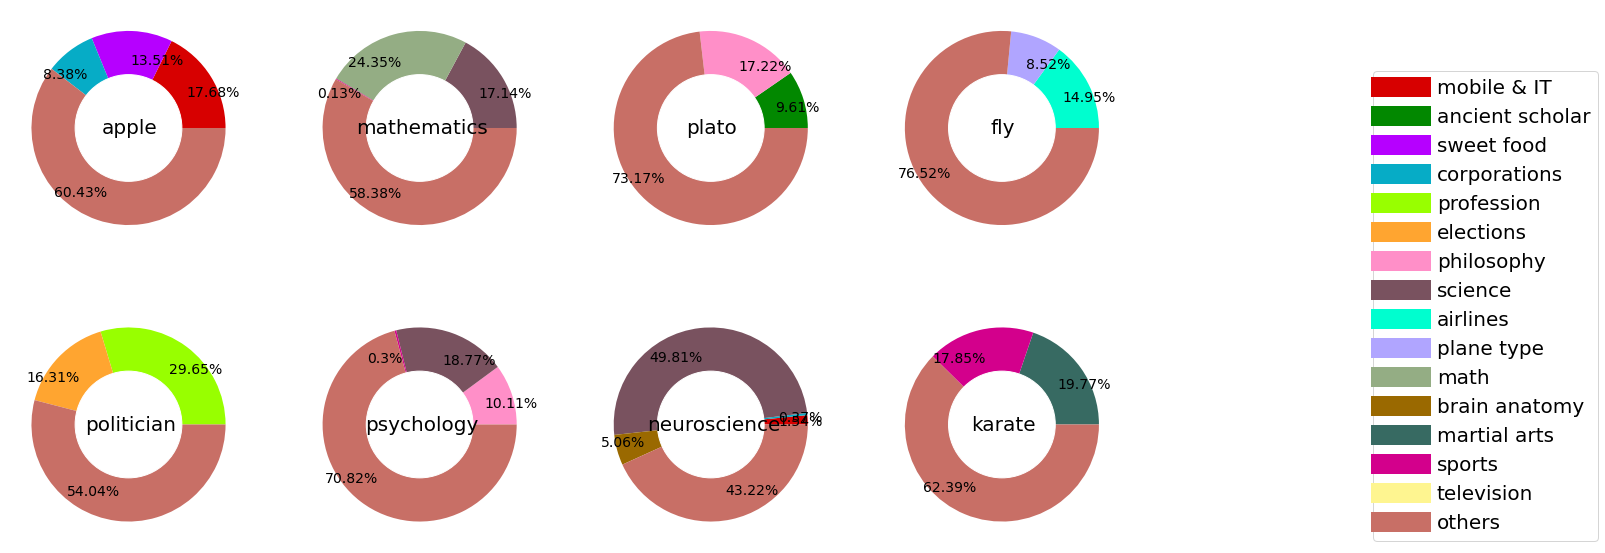

In [29]:
word_factors_decomposition_vis(A, topic_dict_reversed, w2i, topics, words, line=4, save='decomp')

In [30]:
# Function for visualizing differnce in activation of certain word factor in a specified group of words/

def factor_act_vis(A, w2i, factor_words, factor, title='', save=''):
    
    flatten_words = list(sum(factor_words,()))
    
    sorted_words = [word for word in flatten_words[0::2]] + [word for word in flatten_words[1::2]]
    sorted_factors = np.array([A[w2i[word], factor] for word in sorted_words])

    X = np.array(sorted_factors)

    xticks = np.arange(X.shape[0])

    fig, ax = plt.subplots()
    ax.bar(xticks, X)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linewidth=0.3)
    plt.xticks(xticks, sorted_words, rotation=45)
    plt.title(title)
    plt.xlabel('words')
    plt.ylabel('activations')
    if save:
        plt.savefig(save)
        print('Saved plot...')
    plt.show()

In [31]:
factor_words = [('swim', 'swimmer'), ('church', 'clergyman'), ('entertain', 'entertainer'),
             ('work', 'worker'), ('business', 'businessman'), ('law', 'lawyer')]

Saved plot...


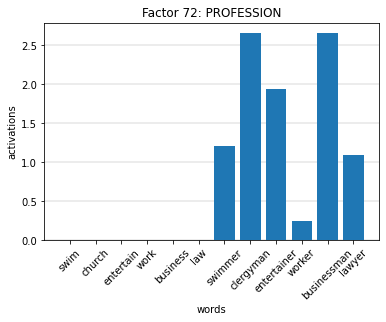

In [32]:
factor_act_vis(A, w2i, factor_words, 72, 'Factor 72: PROFESSION', 'profession_factor')

In [33]:
factor_words = [('think', 'thinking'), ('walk', 'walking'), ('jump', 'jumping'),
             ('go', 'going'), ('fly', 'flying'), ('stay', 'staying')]

Saved plot...


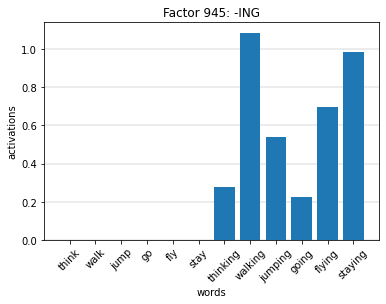

In [34]:
factor_act_vis(A, w2i, factor_words, 945, 'Factor 945: -ING', '-ing_factor')

In [35]:
# Training Nearest Neighbor classifier

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(y)

In [36]:
# Functions for performing manipulations on pretrained word embeddings by adding specified multipliers
# of word factors and finding closest matching word embedding after applying manipulation

# Find nearest vector, compares vector to every word embedding giving closest match
def find_nearest(word, y, nbrs, w2i):
    vector = y[w2i[word]][None, :]
    distances, indicies = nbrs.kneighbors(vector)
    return distances[0, 1], indicies[0, 1]
          

# Given word, factor and multiplier performs manipulation and finds closest matching vector
def check_closest(word, factor, multiplier, y, nbrs, Phi, w2i, i2w, topic_dict):
    check =  y[w2i[word]] + multiplier * Phi[topic_dict[factor]]
    distances, indices = nbrs.kneighbors(check[None, :])
    return distances, indices, i2w[indices[0][0]], i2w[indices[0][1]]


# Check list of words by adding specified multipliy of factor
def check_all(words, factor, multiplier, y, nbrs, Phi, w2i, i2w, topic_dict_reversed):
    for word in words:
        dists, _, first, second = check_closest(word, factor, multiplier, y, nbrs, Phi, w2i, i2w, topic_dict_reversed)
        print('{} => {}: {}, {}: {}'.format(word, np.round(dists[0, 0], 2), first, np.round(dists[0, 1], 2), second))

In [37]:
word = 'poetry'
dist, idx = find_nearest(word, y, nbrs, w2i)
print('Word: {}, Dist: {}'.format(i2w[idx], dist))

Word: poems, Dist: 4.426261906581311


In [38]:
words = ['poetry', 'music', 'church', 'business', 'school', 'sport', 'law', 
         'politics', 'mine', 'car', 'computer', 'science', 'farm', 'swim', 'work']
factor = 'profession'
multiplier = 5

check_all(words, factor, multiplier, y, nbrs, Phi, w2i, i2w, topic_dict_reversed)

poetry => 5.0: poetry, 5.32: poet
music => 5.0: music, 5.57: musician
church => 5.0: church, 6.98: catholic
business => 5.0: business, 6.01: entrepreneur
school => 5.0: school, 6.07: teacher
sport => 5.0: sport, 6.81: athlete
law => 5.0: law, 7.04: laws
politics => 5.0: politics, 6.39: politician
mine => 5.0: mine, 7.23: miner
car => 5.0: car, 6.1: driver
computer => 5.0: computer, 6.95: programmer
science => 5.0: science, 6.29: scientist
farm => 5.0: farm, 5.99: farmer
swim => 5.0: swim, 6.93: swimmer
work => 5.0: work, 5.49: working


In [39]:
words = ['good', 'weak', 'big', 'small', 'cool', 
         'hot', 'short', 'high', 'happy', 'dark' , 'bright']
factor = 'superlative'
multiplier = 5

check_all(words, factor, multiplier, y, nbrs, Phi, w2i, i2w, topic_dict_reversed)

good => 5.0: good, 5.46: thing
weak => 5.0: weak, 6.21: weakest
big => 5.0: big, 5.15: biggest
small => 5.0: small, 5.39: smallest
cool => 5.0: cool, 6.21: coolest
hot => 5.0: hot, 5.77: hottest
short => 5.0: short, 6.13: ever
high => 5.0: high, 5.87: highest
happy => 5.0: happy, 5.92: ever
dark => 5.0: dark, 6.48: darkest
bright => 5.0: bright, 5.97: brightest


In [40]:
# Perform principal components analysis based on pairs of words that share fixed difference in meaning

def perform_pca(y, w2i, pca_words, n_components=2):
    
    from sklearn.decomposition import PCA
    
    X = np.array([[y[w2i[word_pair[0]]], y[w2i[word_pair[1]]]] for word_pair in pca_words])
    X = X.reshape(-1, 300)
    pca = PCA(n_components=n_components)
    pca.fit(X)
    print('Variance explained: ', pca.explained_variance_ratio_)
    X_t = pca.transform(X)
    print('X_t:\n', X_t)
    return X_t

In [41]:
# Function for visualizing two first principal components for group of paired words

def pca_vis(X_t, targets, colors=['r', 'g'], save=''):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = ['From', 'Profession']
    colors = ['r', 'g']

    ax.scatter(X_t[0::2, 0], X_t[0::2, 1], c=colors[0], s=50)   
    ax.scatter(X_t[1::2, 0], X_t[1::2, 1], c=colors[1], s=50)

    ax.legend(targets)

    for i, txt in enumerate(pca_words):
        i = 2 * i
        ax.annotate(txt[0], (X_t[i, 0], X_t[i, 1]))
        ax.annotate(txt[1], (X_t[i + 1, 0], X_t[i + 1, 1]))
        plt.plot([X_t[i, 0], X_t[i + 1, 0]], [X_t[i, 1], X_t[i + 1, 1]], '--', c='b')

    ax.grid()
    
    if save:
        plt.savefig(save)
        print('Saved plot...')

In [42]:
pca_words = [('swim', 'swimmer'), ('poetry', 'poet'), ('sport', 'athlete'),
             ('mine', 'miner'), ('business', 'entrepreneur'), ('school', 'teacher')]

In [43]:
X_t = perform_pca(y, w2i, pca_words)

Variance explained:  [0.19981644 0.18565785]
X_t:
 [[-3.75946747 -1.36414683]
 [-3.49779128 -3.53979794]
 [ 4.34497663 -1.61985412]
 [ 4.601875   -2.47103715]
 [-1.87189288 -0.70313503]
 [-2.02078825 -2.87333107]
 [-1.07300396  5.32724669]
 [-1.20794499  3.21661584]
 [ 0.4719213   2.17476861]
 [ 0.90696178  0.17015623]
 [ 1.05056772  1.25372143]
 [ 2.05458641  0.42879333]]


Saved plot...


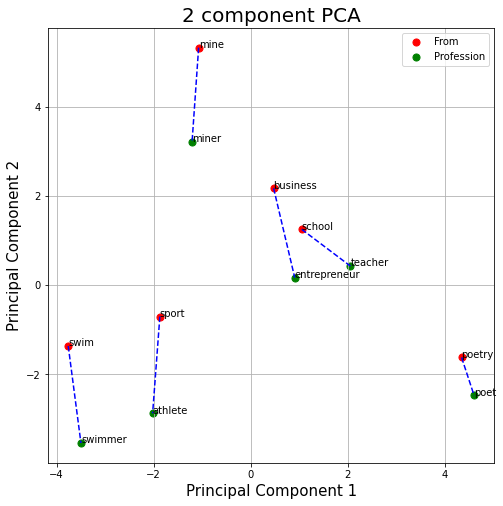

In [44]:
pca_vis(X_t, ['From', 'Profession'], save='pca_profession')

In [45]:
# Function for visualizing results of manipulations applied to word embeddings by adding specified
# word factors

def manipulations_table(data):
    
    from matplotlib.font_manager import FontProperties
    
    fig, ax = plt.subplots()
    
    rows = []
    for row in data:
        col1 = r'$V_{{{}}} + {}F_{{{}}}$'.format(row[0], row[1], row[2])
        col2 = r'$V_{{{}}}$'.format(row[3])
        rows.append([col1, col2])
    
    columns = ['Manipulations', '2nd Nearest Neighbor']

    table = ax.table(cellText=rows, colLabels=columns, loc='center', cellLoc='center', rowLoc='center')
    
    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold', family='sans-serif', size=15))
        else:
            cell.set_text_props(fontproperties=FontProperties(style='italic', size=12))
        

    table.scale(1,2)
    ax.axis('off')
    plt.show()

In [46]:
data = [('swim', 5, 'profession', 'swimmer'), 
        ('miner', 5, 'profession', 'miner'), 
        ('school', 5, 'profession', 'teacher'), 
        ('sport', 5, 'profession', 'athlete')]

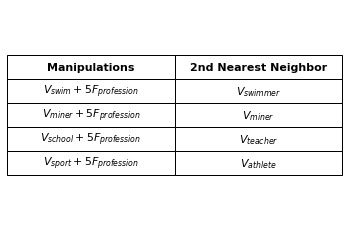

In [47]:
manipulations_table(data)

In [48]:
# Function for visualizing top activation words for specified word factors in 
# a transparent way

def top_activation_table(A, topic_dict, topics, total_activation=20, top_words=30, per_row=7, save=''):
    
    from matplotlib.font_manager import FontProperties
    
    fig, ax = plt.subplots()
    
    rows = []
    for topic in topics:
        factor = topic_dict[topic]
        words = get_top_words(A, factor, total_activation, top_words)
        col1 = '{}\n\"{}"'.format(factor, topic)
    
        lines_num = int(np.ceil(len(words) / per_row))
        lines = []
        for i, line in enumerate(range(lines_num)):
            lines.append(', '.join(words[(i * per_row): (i + 1) * per_row]))
        col2 = '\n'.join(lines)
        
        rows.append([col1, col2])
    
    columns = ['Factors', 'Top activation words']
    colWidths = [1, 2]

    table = ax.table(cellText=rows, colLabels=columns, colWidths=colWidths, loc='center', cellLoc='center', rowLoc='center')
    table.witdth = 10
    table.height = 10
    for (row, col), cell in table.get_celld().items():
        if col == 0:
            cell.set_width(0.3)
        else:
            cell.set_width(2)
        if (row == 0):
            cell.set_height(0.15)
            cell.set_text_props(fontproperties=FontProperties(weight='bold', family='sans-serif'))
        else:
            cell.set_height(0.25)
            cell.set_text_props(fontproperties=FontProperties(style='italic'))
        if row != 0 and col == 1:
            cell._loc = 'left'
            cell.PAD = 0.01
        
    table.auto_set_font_size(False)
    table.set_fontsize(26)
    table.scale(2, 2)
    
    ax.axis('off')
    
    if save:
        plt.savefig(save, bbox_inches='tight')
        print('Saved plot...')
        
    plt.show()

In [49]:
topics = ['space', 'elections', 'food', 'philosophy', 'insects', 'science', 'computer', 'injuries']
total_activation = 10
top_words = 20

Factor 0 10% of activation consists of 235 words
Factor 974 10% of activation consists of 148 words
Factor 152 10% of activation consists of 152 words
Factor 66 10% of activation consists of 197 words
Factor 667 10% of activation consists of 175 words
Factor 394 10% of activation consists of 165 words
Factor 193 10% of activation consists of 167 words
Factor 129 10% of activation consists of 150 words
Saved plot...


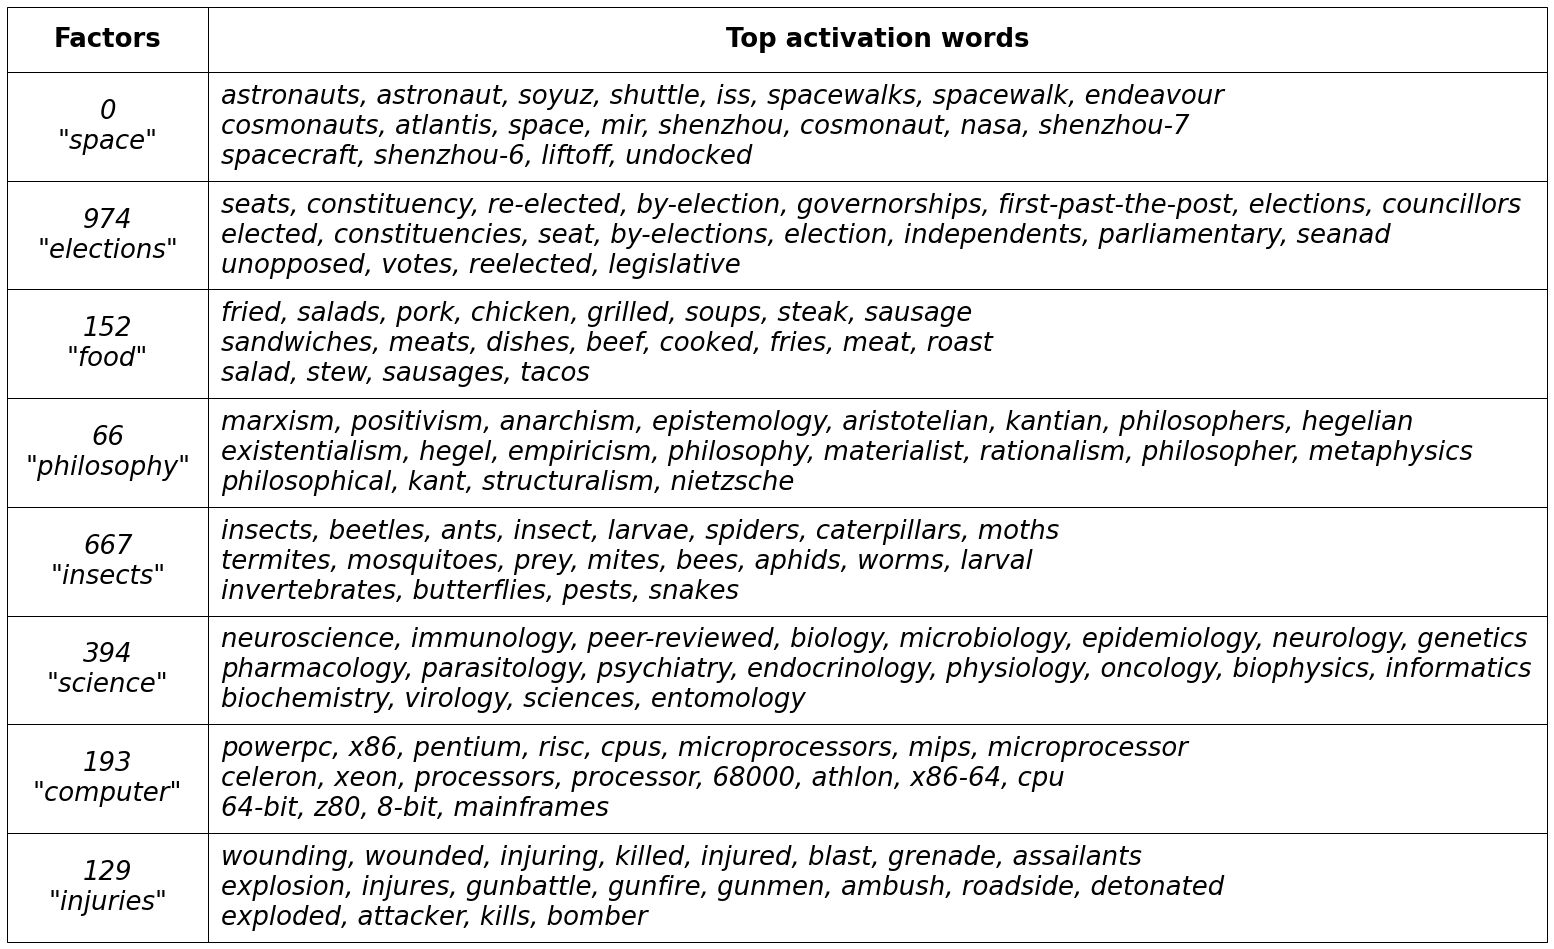

In [50]:
top_activation_table(A, topic_dict_reversed, topics, total_activation, top_words, per_row=8, save='act_table')